<hr style="border:none;height:6px;background:#fff;margin:1em 0;">


<div style="text-align: center;">
  <h1>Empirical Asset Pricing with ML in Europe</h1>
  <h3>HEC Liege</h3>
  <h4><em>Lucas Dubois and Myriam Lamborelle</em></h4>
</div>

<hr style="border:none;height:6px;background:#fff;margin:1em 0;">


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import os
import re
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from dateutil.relativedelta import relativedelta
from statsmodels.stats import diagnostic
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.sandwich_covariance import se_cov
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from stargazer.stargazer import Stargazer
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
from sklearn.linear_model import HuberRegressor

In [138]:
path="/Users/lucasdubois/Desktop/LaTeX/EAP-ML/CODE/DATA/"

In [139]:
figure_path="/Users/lucasdubois/Desktop/LaTeX/EAP-ML/CODE/Images/"

In [414]:
offwhite = (230/255, 230/255, 220/255)
midnight = (0/255, 22/255, 36/255)
steelblue = (171/255, 193/255, 223/255)
primaryred = (127/255, 20/255, 22/255)
harmonizedblue =(48/255,88/255,140/255)

<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>1</small>&nbsp;&nbsp;&nbsp;&nbsp;Database:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">








<div style="text-align: align;">
  <h3> <small>1.1</small>&nbsp;&nbsp;&nbsp;&nbsp;Stocks:</h3>
</div>

In [145]:
df = pd.read_excel(path + "stoxx600.xlsx")

df.rename(columns={df.columns[0]: "Date"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [146]:
df = df.loc[:, ~df.columns.str.startswith("#ERROR")]

In [147]:
df_long = df.melt(
    id_vars="Date",
    var_name="col",
    value_name="value"
)

In [148]:
df_long[["Stock", "Datatype"]] = (
    df_long["col"]
    .str.split(" - ", n=1, expand=True)
)

In [149]:
df_panel = (
    df_long
    .pivot_table(
        index=["Date", "Stock"],
        columns="Datatype",
        values="value"
    )
    .reset_index()
)


In [150]:
df_panel = df_panel.sort_values(["Stock", "Date"])

print(df_panel.head())
print(df_panel.tail())
print(df_panel.info())


Datatype       Date     Stock  DIVIDEND YIELD  MARKET VALUE  \
0        2005-01-01  3I GROUP            2.13       4085.77   
435      2005-02-01  3I GROUP            2.00       4355.70   
871      2005-03-01  3I GROUP            2.04       4279.01   
1307     2005-04-01  3I GROUP            2.11       4134.96   
1743     2005-05-01  3I GROUP            2.23       3913.99   

Datatype  MRKT VALUE TO BOOK   PER  PRICE INDEX  TOT RETURN IND  \
0                       1.12  30.4        244.9          302.56   
435                     1.20  32.4        261.0          322.55   
871                     1.18  31.8        256.4          316.87   
1307                    1.03  30.7        247.4          305.74   
1743                    0.98  29.1        234.6          289.84   

Datatype  TURNOVER BY VALUE  TURNOVER BY VOLUME  
0                  340749.3             83500.9  
435                338096.4             81321.8  
871                446679.1            100759.9  
1307              

In [151]:
df_panel["Stock"].nunique()

599

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>1.2</small>&nbsp;&nbsp;&nbsp;&nbsp;Risk-Free:</h3>
</div>

In [154]:
rf_df = pd.read_excel(path + "EURIBOR.xlsx", header=None)

In [155]:
rf_df.columns = rf_df.iloc[0]
rf_df = rf_df.iloc[1:].reset_index(drop=True)


In [156]:
rf_df.head()
rf_df.columns


Index(['DATE', 'TIME PERIOD', 'OBS.VALUE'], dtype='object', name=0)

In [157]:
rf_df = rf_df.rename(columns={
    "DATE": "Date",
    "OBS.VALUE": "Rf"
})
rf_df = rf_df.drop(columns=["TIME PERIOD"])

In [158]:
rf_df["Date"] = pd.to_datetime(rf_df["Date"])
rf_df["Rf"] = rf_df["Rf"].astype(float) / 100 / 12

In [159]:
rf_df["Date"] = rf_df["Date"] + pd.offsets.MonthBegin(1)


In [160]:
rf_df.head

<bound method NDFrame.head of 0         Date        Rf
0   2005-01-01  0.001806
1   2005-02-01  0.001759
2   2005-03-01  0.001753
3   2005-04-01  0.001753
4   2005-05-01  0.001754
..         ...       ...
247 2025-08-01  0.001577
248 2025-09-01  0.001575
249 2025-10-01  0.001581
250 2025-11-01  0.001589
251 2025-12-01  0.001588

[252 rows x 2 columns]>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>1.3</small>&nbsp;&nbsp;&nbsp;&nbsp;Merging:</h3>
</div>

In [163]:
df_almost = df_panel.merge(
    rf_df,
    on="Date",
    how="left"
)

In [164]:
df_almost["Rf"].describe()

count    133070.000000
mean          0.000881
std           0.001363
min          -0.000497
25%          -0.000308
50%           0.000216
75%           0.001866
max           0.004026
Name: Rf, dtype: float64

In [165]:
df_almost.to_csv(path + "Data1.csv", index=False)

<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>2</small>&nbsp;&nbsp;&nbsp;&nbsp;Data Management:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>2.1</small>&nbsp;&nbsp;&nbsp;&nbsp;From Long to Panel</h3>
</div>

In [170]:
cols = df_almost.columns.tolist()
cols_no_date = [c for c in cols if c != "Date"]


In [171]:
df_long = df_almost.melt(
    id_vars=["Date", "Stock"],
    var_name="Variable",
    value_name="value"
)

In [172]:
df_long.columns


Index(['Date', 'Stock', 'Variable', 'value'], dtype='object')

In [173]:
df_long.columns
df_long.head()

,Date,Stock,Variable,value
0,2005-01-01,3I GROUP,DIVIDEND YIELD,2.13
1,2005-02-01,3I GROUP,DIVIDEND YIELD,2.00
2,2005-03-01,3I GROUP,DIVIDEND YIELD,2.04
3,2005-04-01,3I GROUP,DIVIDEND YIELD,2.11
4,2005-05-01,3I GROUP,DIVIDEND YIELD,2.23


In [174]:
df_panel = (
    df_long
    .pivot_table(
        index=["Date", "Stock"],
        columns="Variable",
        values="value"
    )
    .reset_index()
)

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>2.2.</small>&nbsp;&nbsp;&nbsp;&nbsp;Excess Returns:</h3>
</div>

In [177]:
df_panel["RET"] = (
    df_panel
    .groupby("Stock")["TOT RETURN IND"]
    .pct_change(fill_method=None)
)

In [178]:
df_panel["RET_FWD"] = df_panel.groupby("Stock")["RET"].shift(-1)
df_panel["EXCESS_RET_FWD"] = df_panel["RET_FWD"] - df_panel["Rf"]


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>2.3</small>&nbsp;&nbsp;&nbsp;&nbsp;Firm Characteristics:</h3>
</div>

In [181]:
def safe_log(x):
    out = np.full_like(x, np.nan, dtype="float64")
    mask = x > 0
    out[mask] = np.log(x[mask])
    return out

In [182]:
df_panel["LOG_PRICE"] = safe_log(df_panel["PRICE INDEX"])
df_panel["SIZE"]      = safe_log(df_panel["MARKET VALUE"])
df_panel["BM"]        = 1 / df_panel["MRKT VALUE TO BOOK"]
df_panel["DY"]        = df_panel["DIVIDEND YIELD"] / 100
df_panel["EY"]        = 1 / df_panel["PER"]

df_panel["TURN_VAL"]  = safe_log(df_panel["TURNOVER BY VALUE"])
df_panel["TURN_VOL"]  = safe_log(df_panel["TURNOVER BY VOLUME"])

df_panel["MOM3"]  = (
    df_panel.groupby("Stock")["LOG_PRICE"]
            .transform(lambda s: s.shift(2) - s.shift(5))
)

df_panel["MOM12"] = (
    df_panel.groupby("Stock")["LOG_PRICE"]
            .transform(lambda s: s.shift(2) - s.shift(13))
)

df_panel["VOL12"] = (
    df_panel.groupby("Stock")["RET"]
            .rolling(12, min_periods=12)
            .std()
            .reset_index(level=0, drop=True)
)

df_panel["VOL12"] = df_panel.groupby("Stock")["VOL12"].shift(1)

market_cols = ["SIZE","TURN_VAL","TURN_VOL","LOG_PRICE"]
df_panel[market_cols] = (
    df_panel.groupby("Stock")[market_cols].shift(1)
)

fund_cols = ["BM","DY","EY"]
df_panel[fund_cols] = (
    df_panel.groupby("Stock")[fund_cols].shift(6)
)


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>2.4</small>&nbsp;&nbsp;&nbsp;&nbsp;Interaction Terms:</h3>
</div>

In [185]:
df_panel["SIZE_BM"]   = df_panel["SIZE"] * df_panel["BM"]
df_panel["SIZE_MOM"]  = df_panel["SIZE"] * df_panel["MOM12"]
df_panel["SIZE_VOL"]  = df_panel["SIZE"] * df_panel["VOL12"]
df_panel["SIZE_LIQ"]  = df_panel["SIZE"] * df_panel["TURN_VAL"]
df_panel["BM_MOM"] = df_panel["BM"] * df_panel["MOM12"]
df_panel["BM_VOL"] = df_panel["BM"] * df_panel["VOL12"]
df_panel["BM_LIQ"] = df_panel["BM"] * df_panel["TURN_VAL"]
df_panel["MOM_VOL"] = df_panel["MOM12"] * df_panel["VOL12"]
df_panel["MOM_LIQ"] = df_panel["MOM12"] * df_panel["TURN_VAL"]
df_panel["MOM_PRICE"] = df_panel["MOM12"] * df_panel["LOG_PRICE"]
df_panel["EY_MOM"] = df_panel["EY"] * df_panel["MOM12"]
df_panel["DY_SIZE"] = df_panel["DY"] * df_panel["SIZE"]

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>2.5</small>&nbsp;&nbsp;&nbsp;&nbsp;Standarization & Winsorization :</h3>
</div>

In [188]:
characteristics = [
    "SIZE","BM","DY","EY","MOM3","MOM12","VOL12",
    "TURN_VAL","TURN_VOL","LOG_PRICE"
]

interaction_terms = [
    "SIZE_BM","SIZE_MOM","SIZE_VOL","SIZE_LIQ",
    "BM_MOM","BM_VOL","BM_LIQ",
    "MOM_VOL","MOM_LIQ","MOM_PRICE",
    "EY_MOM","DY_SIZE"
]

predictors = characteristics + interaction_terms

In [189]:
print(df_panel.head())

Variable       Date                Stock  DIVIDEND YIELD  MARKET VALUE  \
0        2005-01-01             3I GROUP            2.13       4085.77   
1        2005-01-01  A P MOLLER MAERSK B            0.66     100668.40   
2        2005-01-01                  A2A            2.94       3060.08   
3        2005-01-01             AALBERTS            1.54        878.29   
4        2005-01-01            ABB LTD N            0.00      13477.75   

Variable  MRKT VALUE TO BOOK   PER  PRICE INDEX        Rf  TOT RETURN IND  \
0                       1.12  30.4        244.9  0.001806          302.56   
1                       1.75   9.1       5126.9  0.001806         6348.85   
2                       1.86  15.7        199.7  0.001806          231.36   
3                       2.94  20.4       1378.8  0.001806         1844.24   
4                       2.93  10.4        292.8  0.001806          579.90   

Variable  TURNOVER BY VALUE  ...  SIZE_VOL  SIZE_LIQ  BM_MOM  BM_VOL  BM_LIQ  \
0           

In [190]:
print(f'We have {len(predictors)} ({len(characteristics)} characteristics and {len(interaction_terms)} interaction terms)')

We have 22 (10 characteristics and 12 interaction terms)


But first, following the GKN

In [192]:
class CSStandardizer:
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper
        self.q_low = None
        self.q_high = None
        self.mean = None
        self.std = None

    def fit(self, df, cols):
        self.q_low  = df[cols].quantile(self.lower)
        self.q_high = df[cols].quantile(self.upper)
        self.mean   = df[cols].mean()
        self.std    = df[cols].std()
        return self

    def transform(self, df, cols):
        x = df[cols].clip(self.q_low, self.q_high, axis=1)
        z = (x - self.mean) / self.std

        return z.fillna(0.0)


In [193]:
df_FINAL= df_panel

In [194]:
df_FINAL.to_csv(path + "FINAL.csv", index=False)

<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>3</small>&nbsp;&nbsp;&nbsp;&nbsp;Validation:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">

<div style="text-align: align;">
  <h3> <small>3.1</small>&nbsp;&nbsp;&nbsp;&nbsp; Rolling Window Cross-Validation:</h3>
</div>

In [420]:
class RollingPanelSplit:
    """
    Rolling time-based split for panel data (Date × Stock)

    Parameters
    ----------
    train_months : int
        Length of training window in months
    val_months : int or None
        Length of validation window in months (None = no validation)
    test_months : int
        Length of test window in months
    step_months : int
        Step size of the rolling window
    """

    def __init__(self,
                 train_months=120,
                 val_months=None,
                 test_months=12,
                 step_months=12):

        self.train_months = train_months
        self.val_months = val_months
        self.test_months = test_months
        self.step_months = step_months

    def split(self, df, date_col="Date"):
        """
        Returns a list of (train_idx, val_idx, test_idx)
        """

        df = df.sort_values(date_col).copy()
        dates = df[date_col].drop_duplicates().sort_values()

        splits = []

        start = dates.min() + relativedelta(months=self.train_months)

        while True:
            train_start = start - relativedelta(months=self.train_months)
            train_end = start

            if self.val_months is not None:
                val_end = train_end + relativedelta(months=self.val_months)
                test_end = val_end + relativedelta(months=self.test_months)
            else:
                val_end = None
                test_end = train_end + relativedelta(months=self.test_months)

            if test_end > dates.max():
                break

            train_idx = df[
                (df[date_col] >= train_start) &
                (df[date_col] < train_end)
            ].index

            if self.val_months is not None:
                val_idx = df[
                    (df[date_col] >= train_end) &
                    (df[date_col] < val_end)
                ].index
            else:
                val_idx = None

            test_idx = df[
                (df[date_col] >= (val_end if val_end else train_end)) &
                (df[date_col] < test_end)
            ].index

            splits.append((train_idx, val_idx, test_idx))

            start += relativedelta(months=self.step_months)

        return splits


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>4</small>&nbsp;&nbsp;&nbsp;&nbsp;Indicators Functions:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>4.1</small>&nbsp;&nbsp;&nbsp;&nbsp; $R^2_{OOS}$ &nbsp;Function:</h3>
</div>

In [204]:
def oos_r2(df, y_true="y_true", y_pred="y_pred", date_col="Date"):
    df = df.copy()
    df = df.sort_values(date_col)

    m = df.groupby(date_col)[y_true].mean()
    m_hist = m.expanding().mean().shift(1)

    df["mean_fc"] = df[date_col].map(m_hist)

    valid = (
        df["mean_fc"].notna()
        & df[y_true].notna()
        & df[y_pred].notna()
    )

    if valid.sum() == 0:
        return np.nan

    sse = ((df.loc[valid, y_true] - df.loc[valid, y_pred]) ** 2).sum()
    sst = ((df.loc[valid, y_true] - df.loc[valid, "mean_fc"]) ** 2).sum()

    if not np.isfinite(sst) or sst <= 0:
        return np.nan

    return 1 - sse / sst



<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>4.2</small>&nbsp;&nbsp;&nbsp;&nbsp; H-L Portifolio Function:</h3>
</div>

In [207]:
def hl_month(df, q=0.1, pred_col="y_pred", ret_col="y_true"):
    """
    High-Low portfolio return for one cross-section
    """
    df = df[[pred_col, ret_col]].dropna()
    if df.empty:
        return np.nan

    q_low = df[pred_col].quantile(q)
    q_high = df[pred_col].quantile(1 - q)

    return (
        df.loc[df[pred_col] >= q_high, ret_col].mean()
        - df.loc[df[pred_col] <= q_low, ret_col].mean()
    )



<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>4.2</small>&nbsp;&nbsp;&nbsp;&nbsp; $Sharpe$ (H-L) Function:</h3>
</div>

In [210]:
def sharpe(returns, periods_per_year=12):
    mean = returns.mean()
    std  = returns.std()
    return np.sqrt(periods_per_year) * mean / std



In [211]:
def sharpe_gkn(returns, oos_r2, periods_per_year=12):
    SR = sharpe(returns, periods_per_year)
    return np.sqrt((SR**2 + oos_r2) / (1 - oos_r2))


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>5</small>&nbsp;&nbsp;&nbsp;&nbsp;OLS:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>5.1</small>&nbsp;&nbsp;&nbsp;&nbsp; Function:</h3>
</div>

In [216]:
splitter = RollingPanelSplit(
    train_months=120,   
    val_months=None,    
    test_months=12,    
    step_months=12      
)
splits = splitter.split(df_FINAL, date_col="Date")

In [217]:
def run_rolling_huber(
    df,
    splits,
    predictors,
    target,
    epsilon=1.35,
    max_iter=1000
):
    """
    Rolling Huber regression benchmark
    - Train + validation used for fitting
    - Train-only cross-sectional standardization
    - Robust to outliers
    - Panel-compatible output
    """

    oos_results = []

    for split_id, (train_idx, val_idx, test_idx) in enumerate(splits):

        train = df.loc[train_idx].copy()
        val   = df.loc[val_idx].copy() if val_idx is not None else None
        test  = df.loc[test_idx].copy()

        train = train.dropna(subset=predictors + [target])
        test  = test.dropna(subset=predictors + [target])
        if val is not None:
            val = val.dropna(subset=predictors + [target])

        if len(train) == 0 or len(test) == 0:
            continue

        stdzr = CSStandardizer(lower=0.01, upper=0.99)
        stdzr.fit(train, predictors)

        X_train = stdzr.transform(train, predictors).values
        y_train = train[target].values

        X_test  = stdzr.transform(test, predictors).values
        y_test  = test[target].values

        if val is not None:
            X_val = stdzr.transform(val, predictors).values
            y_val = val[target].values

            X_fit = np.vstack([X_train, X_val])
            y_fit = np.concatenate([y_train, y_val])
        else:
            X_fit = X_train
            y_fit = y_train

        # ----------------------------
        # Huber regression
        # ----------------------------
        model = HuberRegressor(
            epsilon=epsilon,
            max_iter=max_iter,
            fit_intercept=True
        )

        model.fit(X_fit, y_fit)
        y_pred = model.predict(X_test)

        out = test[["Date", "Stock"]].copy()
        out["y_true"] = y_test
        out["y_pred"] = y_pred
        out["model"]  = "Huber"
        out["split"]  = split_id

        oos_results.append(out)

    return pd.concat(oos_results, ignore_index=True)

In [218]:
target = "EXCESS_RET_FWD"


In [219]:
ols_full = run_rolling_huber(
    df=df_FINAL,
    splits=splits,
    predictors=predictors,
    target=target
)


In [220]:
ols_full.columns


Index(['Date', 'Stock', 'y_true', 'y_pred', 'model', 'split'], dtype='object', name='Variable')

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>5.2</small>&nbsp;&nbsp;&nbsp;&nbsp; Results:</h3>
</div>

In [223]:
r2_ols = oos_r2(ols_full)
print(f"OOS R² (OLS): {r2_ols:.4f}")


OOS R² (OLS): 0.0069


In [224]:
hl_ols_full = (
    ols_full
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(hl_month)
)

In [225]:
sharpe_ols_full = sharpe_gkn(hl_ols_full, r2_ols,periods_per_year=12)
print(f"Sharpe={sharpe(hl_ols_full):.2f}")
print(f"SHARPE (GKN) (OLS H–L): {sharpe_ols_full:.2f}")

Sharpe=1.03
SHARPE (GKN) (OLS H–L): 1.03


In [226]:
ols_full.groupby("Date")["y_pred"].std().describe()


count    120.000000
mean       0.005223
std        0.000830
min        0.003364
25%        0.004632
50%        0.005099
75%        0.005726
max        0.007858
Name: y_pred, dtype: float64

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>5.3</small>&nbsp;&nbsp;&nbsp;&nbsp; Look-Ahead-Bias Check:</h3>
</div>

In [229]:
tmp = ols_full.copy()
tmp["y_pred"] = np.random.randn(len(tmp))

hl_placebo = (
    tmp.groupby("Date")[["y_pred", "y_true"]]
       .apply(hl_month)
)

print("Placebo Sharpe:", sharpe(hl_placebo))


Placebo Sharpe: -0.14295496864168503


In [230]:
for q in [0.1, 0.2, 0.3, 0.4]:
    hl_q = (
        ols_full.groupby("Date")[["y_pred", "y_true"]]
               .apply(lambda m: hl_month(m, q=q))
    )
    print(q, sharpe(hl_q))


0.1 1.0260762981875966
0.2 0.7433472772916978
0.3 0.6929456241595715
0.4 0.7426716591651122


In [231]:
ols_test = ols_full.copy()
ols_test["y_pred"] = ols_test.groupby("Stock")["y_pred"].shift(1)

hl_shifted = (
    ols_test
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(hl_month)
)

print("Shifted Sharpe:", sharpe(hl_shifted))


Shifted Sharpe: 1.0664596302586198


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>6</small>&nbsp;&nbsp;&nbsp;&nbsp; OLS-3:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>6.1</small>&nbsp;&nbsp;&nbsp;&nbsp; Function:</h3>
</div>

In [236]:
predictors_3 = ["SIZE", "BM", "MOM12"]


In [237]:
ols_3 = run_rolling_huber(
    df=df_FINAL,
    splits=splits,
    predictors=predictors_3,
    target=target
)


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>6.2</small>&nbsp;&nbsp;&nbsp;&nbsp; Results:</h3>
</div>

In [240]:
r2_ols3 = oos_r2(ols_3)
print(f"OOS R² (OLS): {r2_ols3:.4f}")


OOS R² (OLS): 0.0093


In [241]:
hl_ols_3 = (
    ols_3
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(hl_month)
)

In [242]:
sharpe_ols_3= sharpe_gkn(hl_ols_3, r2_ols3,periods_per_year=12)

print(f"SHARPE (GKN) (OLS-3 H–L): {sharpe_ols_3:.2f}")


SHARPE (GKN) (OLS-3 H–L): 0.72


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>6.3</small>&nbsp;&nbsp;&nbsp;&nbsp; Look-Ahead-Bias Check:</h3>
</div>

In [245]:
tmp = ols_3.copy()
tmp["y_pred"] = np.random.randn(len(tmp))

hl_placebo = (
    tmp.groupby("Date")[["y_pred", "y_true"]]
       .apply(hl_month)
)

print("Placebo Sharpe:", sharpe(hl_placebo))


Placebo Sharpe: 0.06790641281805446


In [246]:
for q in [0.1, 0.2, 0.3, 0.4]:
    hl_q = (
        ols_3.groupby("Date")[["y_pred", "y_true"]]
               .apply(lambda m: hl_month(m, q=q))
    )
    print(q, sharpe(hl_q))


0.1 0.7144243533184931
0.2 0.7852506658923429
0.3 0.6463491336853878
0.4 0.6233527741943865


In [247]:
ols_test = ols_3.copy()
ols_test["y_pred"] = ols_test.groupby("Stock")["y_pred"].shift(1)

hl_shifted = (
    ols_test
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(hl_month)
)

print("Shifted Sharpe:", sharpe(hl_shifted))


Shifted Sharpe: 0.8032667202087608


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>7</small>&nbsp;&nbsp;&nbsp;&nbsp; Elastic-Net:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>7.1</small>&nbsp;&nbsp;&nbsp;&nbsp; Function:</h3>
</div>

In [252]:
splitter = RollingPanelSplit(
    train_months=120,
    val_months=12,   
    test_months=12,
    step_months=12
)

splits = splitter.split(df_FINAL, date_col="Date")


In [253]:
alpha_grid = np.logspace(-4, 1, 20)
l1_ratio = 0.5  #FOR ELASTIC NET!

In [254]:
def run_rolling_enet(df, splits, predictors, target, alpha_grid, l1_ratio=0.5):
    oos_results = []

    for split_id, (train_idx, val_idx, test_idx) in enumerate(splits):

        # ----------------------------
        # Split data
        # ----------------------------
        train = df.loc[train_idx].copy()
        val   = df.loc[val_idx].copy()
        test  = df.loc[test_idx].copy()

        train = train.dropna(subset=predictors + [target])
        val   = val.dropna(subset=predictors + [target])
        test  = test.dropna(subset=predictors + [target])

        if len(train) == 0 or len(val) == 0 or len(test) == 0:
            continue

        # ----------------------------
        # Standardization (TRAIN ONLY)
        # ----------------------------
        stdzr = CSStandardizer(lower=0.01, upper=0.99)
        stdzr.fit(train, predictors)

        X_train = stdzr.transform(train, predictors).values
        y_train = train[target].values

        X_val = stdzr.transform(val, predictors).values
        y_val = val[target].values

        X_test = stdzr.transform(test, predictors).values
        y_test = test[target].values

        # ----------------------------
        # Hyperparameter tuning (TRAIN → VAL)
        # ----------------------------
        best_alpha = None
        best_mse = np.inf

        for alpha in alpha_grid:
            model = ElasticNet(
                alpha=alpha,
                l1_ratio=l1_ratio,
                fit_intercept=True,
                max_iter=10_000
            )
            model.fit(X_train, y_train)
            val_pred = model.predict(X_val)
            mse = np.mean((y_val - val_pred) ** 2)

            if mse < best_mse:
                best_mse = mse
                best_alpha = alpha

        # ----------------------------
        # Refit on TRAIN ∪ VAL
        # ----------------------------
        X_tv = np.vstack([X_train, X_val])
        y_tv = np.concatenate([y_train, y_val])

        final_model = ElasticNet(
            alpha=best_alpha,
            l1_ratio=l1_ratio,
            fit_intercept=True,
            max_iter=10_000
        )
        final_model.fit(X_tv, y_tv)

        # ----------------------------
        # Predict on TEST
        # ----------------------------
        y_pred = final_model.predict(X_test)

        out = test[["Date", "Stock"]].copy()
        out["y_true"] = y_test
        out["y_pred"] = y_pred
        out["model"]  = "ElasticNet"
        out["alpha"]  = best_alpha
        out["split"]  = split_id

        oos_results.append(out)

    return pd.concat(oos_results, ignore_index=True)


In [255]:
enet_full = run_rolling_enet(
    df=df_FINAL,
    splits=splits,
    predictors=predictors,
    target="EXCESS_RET_FWD",
    alpha_grid=alpha_grid,
    l1_ratio=0.5
)


In [256]:
enet_full["alpha"].describe()
enet_full.groupby("Date")["y_pred"].std().describe()


count    108.000000
mean       0.002972
std        0.002722
min        0.000000
25%        0.000000
50%        0.003572
75%        0.004584
max        0.008171
Name: y_pred, dtype: float64

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>7.2</small>&nbsp;&nbsp;&nbsp;&nbsp; Results:</h3>
</div>

In [259]:
r2_enet = oos_r2(enet_full)
print(f"OOS R² (ENet): {r2_enet:.4f}")


OOS R² (ENet): 0.0081


In [260]:
hl_enet = (
    enet_full
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(lambda m: hl_month(m, q=0.1))
)


In [261]:
sharpe_enet = sharpe_gkn(hl_enet, r2_enet,periods_per_year=12)

print(f"SHARPE (GKN) (OLS H–L): {sharpe_enet:.2f}")

SHARPE (GKN) (OLS H–L): 0.59


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>7.3</small>&nbsp;&nbsp;&nbsp;&nbsp; Look-Ahead-Bias Check:</h3>
</div>

In [264]:
tmp = enet_full.copy()
tmp["y_pred"] = np.random.randn(len(tmp))

hl_placebo = (
    tmp.groupby("Date")[["y_pred", "y_true"]]
       .apply(hl_month)
)

print("Placebo Sharpe:", sharpe(hl_placebo))


Placebo Sharpe: 0.3122603925841668


In [265]:
for q in [0.1, 0.2, 0.3, 0.4]:
    hl_q = (
        enet_full.groupby("Date")[["y_pred", "y_true"]]
               .apply(lambda m: hl_month(m, q=q))
    )
    print(q, sharpe(hl_q))


0.1 0.5791700351638633
0.2 0.5405024661626145
0.3 0.5136890940028711
0.4 0.4462684789543502


In [266]:
enet_test = enet_full.copy()
enet_test["y_pred"] = enet_test.groupby("Stock")["y_pred"].shift(1)

hl_shifted = (
    enet_test
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(hl_month)
)

print("Shifted Sharpe:", sharpe(hl_shifted))


Shifted Sharpe: 0.7321861709725014


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>8</small>&nbsp;&nbsp;&nbsp;&nbsp; Random Forest:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>8.1</small>&nbsp;&nbsp;&nbsp;&nbsp; Function:</h3>
</div>

In [271]:
splitter = RollingPanelSplit(
    train_months=120,
    val_months=12,
    test_months=12,
    step_months=12
)

splits = splitter.split(df_FINAL, date_col="Date")


In [272]:
param_grid1 = {
    "max_depth": [1,2,3,4,5,6],
    "max_features": [3, 6, 12, 24, 46, 49]
}


In [273]:
param_grid = {
    "max_depth": [2, 4, 6],
    "max_features": [int(np.sqrt(len(predictors))), len(predictors)//3]
}

grid = list(ParameterGrid(param_grid))


In [274]:
grid = list(ParameterGrid(param_grid))

In [275]:
from sklearn.ensemble import RandomForestRegressor

def run_rolling_rf_gkn_style(df, splits, predictors, target, grid, random_state=42):

    predictions = []
    y_test_list = []
    dates = []
    dic_r2_all = {}
    dic_max_depth_all = {}

    for split_id, (train_idx, val_idx, test_idx) in enumerate(splits):

        # ----------------------------
        # Split data
        # ----------------------------
        train = df.loc[train_idx].copy()
        val   = df.loc[val_idx].copy()
        test  = df.loc[test_idx].copy()

        train = train.dropna(subset=predictors + [target])
        val   = val.dropna(subset=predictors + [target])
        test  = test.dropna(subset=predictors + [target])

        if len(train) == 0 or len(val) == 0 or len(test) == 0:
            continue

        # ----------------------------
        # Standardization (TRAIN ONLY)
        # ----------------------------
        stdzr = CSStandardizer(lower=0.01, upper=0.99)
        stdzr.fit(train, predictors)

        X_train = stdzr.transform(train, predictors).values
        y_train = train[target].values

        X_val = stdzr.transform(val, predictors).values
        y_val = val[target].values

        X_test = stdzr.transform(test, predictors).values
        y_test = test[target].values

        # ----------------------------
        # Hyperparameter tuning (TRAIN → VAL)
        # ----------------------------
        mse = np.full(len(grid), np.nan, dtype=np.float64)

        for j, params in enumerate(grid):

            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=params["max_depth"],
                max_features=params["max_features"],
                min_samples_leaf=40,
                n_jobs=-1,
                random_state=random_state
            )

            model.fit(X_train, y_train)
            val_pred = model.predict(X_val)
            mse[j] = np.mean((y_val - val_pred) ** 2)

        best_idx = np.argmin(mse)
        best_params = grid[best_idx]

        dic_max_depth_all[split_id] = best_params["max_depth"]

        # ----------------------------
        # Refit on TRAIN ∪ VAL
        # ----------------------------
        X_tv = np.vstack([X_train, X_val])
        y_tv = np.concatenate([y_train, y_val])

        final_model = RandomForestRegressor(
            n_estimators=200,
            max_depth=best_params["max_depth"],
            max_features=best_params["max_features"],
            min_samples_leaf=40,
            n_jobs=-1,
            random_state=random_state
        )

        final_model.fit(X_tv, y_tv)

        y_pred = final_model.predict(X_test)

        # ----------------------------
        # Store results
        # ----------------------------
        out = test[["Date", "Stock"]].copy()
        out["y_true"] = y_test
        out["y_pred"] = y_pred
        out["model"]  = "RF"
        out["split"]  = split_id
        out["max_depth"] = best_params["max_depth"]
        out["max_features"] = best_params["max_features"]

        predictions.append(out)

    return pd.concat(predictions, ignore_index=True), dic_max_depth_all


In [276]:
rf, rf_depths = run_rolling_rf_gkn_style(
    df=df_FINAL,
    splits=splits,
    predictors=predictors,
    target="EXCESS_RET_FWD",
    grid=grid
)


In [277]:
r2_rf = oos_r2(rf)
print(f"OOS R² (RF): {r2_rf:.4f}")

OOS R² (RF): 0.0111


In [278]:
hl_rf = (
    rf
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(lambda m: hl_month(m, q=0.1))
)


In [279]:
sharpe_rf = sharpe_gkn(hl_rf, r2_rf,periods_per_year=12)

print(f"SHARPE (GKN) (RF): {sharpe_rf:.2f}")

SHARPE (GKN) (RF): 0.74


<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>7.3</small>&nbsp;&nbsp;&nbsp;&nbsp; Look-Ahead-Bias Check:</h3>
</div>

In [282]:
tmp = rf.copy()
tmp["y_pred"] = np.random.randn(len(tmp))

hl_placebo = (
    tmp.groupby("Date")[["y_pred", "y_true"]]
       .apply(hl_month)
)

print("Placebo Sharpe:", sharpe(hl_placebo))


Placebo Sharpe: -0.4731876522565157


In [283]:
for q in [0.1, 0.2, 0.3, 0.4]:
    hl_q = (
        rf.groupby("Date")[["y_pred", "y_true"]]
               .apply(lambda m: hl_month(m, q=q))
    )
    print(q, sharpe(hl_q))

0.1 0.7239904648122159
0.2 0.7535808019926168
0.3 0.6688057715824258
0.4 0.6332876623711859


In [284]:
rf_test = rf.copy()
rf_test["y_pred"] = rf_test.groupby("Stock")["y_pred"].shift(1)

hl_shifted = (
    rf_test
    .groupby("Date")[["y_pred", "y_true"]]
    .apply(hl_month)
)

print("Shifted Sharpe:", sharpe(hl_shifted))


Shifted Sharpe: 0.9572485505286317


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>9</small>&nbsp;&nbsp;&nbsp;&nbsp; Neural Networks:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


<div style="text-align: align;">
  <h3> <small>9.1</small>&nbsp;&nbsp;&nbsp;&nbsp; Function:</h3>
</div>

In [289]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, depth, hidden_dim=64):
        super().__init__()

        layers = []
        d_in = input_dim

        for _ in range(depth):
            layers.append(nn.Linear(d_in, hidden_dim))
            layers.append(nn.ReLU())
            d_in = hidden_dim

        layers.append(nn.Linear(d_in, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze()


In [290]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, depth, hidden_dim=64):
        super().__init__()

        layers = []
        d_in = input_dim

        for _ in range(depth):
            layers.append(nn.Linear(d_in, hidden_dim))
            layers.append(nn.ReLU())
            d_in = hidden_dim

        layers.append(nn.Linear(d_in, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze()


In [291]:
def run_rolling_nn_fixed(
    df,
    splits,
    predictors,
    target,
    depths=(1,2,3,4,5,6),
    lr=1e-3,
    weight_decay=1e-4,
    epochs=50,
    device="cpu"
):
    results = []

    for depth in depths:
        print(f"Running NN depth = {depth}")

        for split_id, (train_idx, val_idx, test_idx) in enumerate(splits):

            train = df.loc[train_idx].dropna(subset=predictors + [target])
            test  = df.loc[test_idx].dropna(subset=predictors + [target])

            if len(train) == 0 or len(test) == 0:
                continue  # data issue only

            # --------- Standardization ----------
            stdzr = CSStandardizer(lower=0.01, upper=0.99).fit(train, predictors)

            X_train = stdzr.transform(train, predictors).values
            y_train = train[target].values
            X_test  = stdzr.transform(test, predictors).values
            y_test  = test[target].values

            X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
            y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
            X_test  = torch.tensor(X_test,  dtype=torch.float32, device=device)

            # --------- Model ----------
            model = FeedForwardNN(X_train.shape[1], depth).to(device)

            optimizer = optim.Adam(
                model.parameters(),
                lr=lr,
                weight_decay=weight_decay
            )

            loss_fn = nn.MSELoss()
            failed = False

            # --------- Training ----------
            for _ in range(epochs):
                optimizer.zero_grad()
                y_hat = model(X_train)
                loss = loss_fn(y_hat, y_train)

                if torch.isnan(loss):
                    failed = True
                    break

                loss.backward()
                optimizer.step()

            # --------- Prediction (NO SKIPPING) ----------
            if failed:
                y_pred = np.full(len(test), y_train.mean().item())
            else:
                with torch.no_grad():
                    y_pred = model(X_test).cpu().numpy()

            # --------- Store ----------
            out = test[["Date", "Stock"]].copy()
            out["y_true"] = y_test
            out["y_pred"] = y_pred
            out["model"]  = f"NN{depth}"
            out["split"]  = split_id

            results.append(out)

    return pd.concat(results, ignore_index=True)


In [292]:
nn_preds = run_rolling_nn_fixed(
    df=df_FINAL,
    splits=splits,
    predictors=predictors,
    target="EXCESS_RET_FWD",
    depths=[1,2,3,4,5,6],
    lr=1e-3,
    weight_decay=1e-4,
    epochs=50
)


Running NN depth = 1
Running NN depth = 2
Running NN depth = 3
Running NN depth = 4
Running NN depth = 5
Running NN depth = 6


In [293]:
nn_preds.groupby("model")["split"].nunique()


model
NN1    9
NN2    9
NN3    9
NN4    9
NN5    9
NN6    9
Name: split, dtype: int64

In [294]:
for d in [1, 2, 3, 4, 5, 6]:
    tmp = nn_preds[nn_preds["model"] == f"NN{d}"]

    r2 = oos_r2(tmp)

    hl = (
        tmp.groupby("Date")[["y_pred", "y_true"]]
           .apply(lambda m: hl_month(m, q=0.1))
    )

    print(
        f"NN{d}:  OOS R²={r2:.4f},  "
        f"Sharpe={sharpe(hl):.2f},  "
        f"GKN Sharpe={sharpe_gkn(hl, r2):.2f}"
    )


/var/folders/p5/t5sm1d6n089bmxvpwkzk17hr0000gn/T/ipykernel_27250/2202750746.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((SR**2 + oos_r2) / (1 - oos_r2))


NN1:  OOS R²=-0.1807,  Sharpe=0.35,  GKN Sharpe=nan
NN2:  OOS R²=-0.0154,  Sharpe=0.42,  GKN Sharpe=0.40
NN3:  OOS R²=0.0063,  Sharpe=0.61,  GKN Sharpe=0.61
NN4:  OOS R²=0.0120,  Sharpe=0.72,  GKN Sharpe=0.73
NN5:  OOS R²=0.0150,  Sharpe=0.67,  GKN Sharpe=0.68
NN6:  OOS R²=0.0162,  Sharpe=0.85,  GKN Sharpe=0.87


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>10</small>&nbsp;&nbsp;&nbsp;&nbsp; PCR:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


In [298]:
def run_rolling_pcr(
    df,
    splits,
    predictors,
    target="EXCESS_RET_FWD",
    K_grid=(0, 1, 2, 3, 5, 8, 10, 15, 22),
    model_name="OLS+PCA",
):
    """
    Rolling Principal Components Regression (PCR):
      - Standardize (winsor + z-score) using TRAIN only
      - PCA fit on TRAIN X only
      - choose K using VALIDATION MSE
      - refit on TRAIN ∪ VAL with chosen K
      - predict TEST

    Output columns match your other models:
      Date | Stock | y_true | y_pred | model | K | split
    """
    out_all = []

    for split_id, (train_idx, val_idx, test_idx) in enumerate(splits):

        train = df.loc[train_idx].copy()
        val   = df.loc[val_idx].copy() if val_idx is not None else None
        test  = df.loc[test_idx].copy()

        # drop rows missing target or predictors
        train = train.dropna(subset=predictors + [target])
        test  = test.dropna(subset=predictors + [target])
        if val is not None:
            val = val.dropna(subset=predictors + [target])

        if len(train) == 0 or len(test) == 0 or (val is not None and len(val) == 0):
            continue

        # ---------- Standardize using TRAIN only ----------
        stdzr = CSStandardizer(lower=0.01, upper=0.99).fit(train, predictors)

        X_tr = stdzr.transform(train, predictors).values
        y_tr = train[target].values

        X_te = stdzr.transform(test, predictors).values
        y_te = test[target].values

        if val is not None:
            X_va = stdzr.transform(val, predictors).values
            y_va = val[target].values
        else:
            # if no val window, we just pick max(K_grid) (or 0) and proceed
            X_va, y_va = None, None

        # ---------- Choose K on validation ----------
        best_K = None
        best_mse = np.inf

        for K in K_grid:
            # K=0 means plain OLS on standardized predictors (no PCA)
            if K == 0:
                Z_tr = X_tr
                Z_va = X_va if X_va is not None else None
            else:
                K_eff = min(K, X_tr.shape[1])  # safety
                pca = PCA(n_components=K_eff)
                Z_tr = pca.fit_transform(X_tr)
                Z_va = pca.transform(X_va) if X_va is not None else None

            reg = LinearRegression().fit(Z_tr, y_tr)

            if X_va is None:
                # no validation: just take the first K and break
                best_K = K
                break

            mse = np.mean((y_va - reg.predict(Z_va)) ** 2)
            if mse < best_mse:
                best_mse = mse
                best_K = K

        # ---------- Refit on TRAIN ∪ VAL ----------
        if val is not None:
            X_tv = np.vstack([X_tr, X_va])
            y_tv = np.concatenate([y_tr, y_va])
        else:
            X_tv, y_tv = X_tr, y_tr

        if best_K == 0:
            Z_tv = X_tv
            Z_te = X_te
        else:
            K_eff = min(best_K, X_tv.shape[1])
            pca = PCA(n_components=K_eff)
            Z_tv = pca.fit_transform(X_tv)
            Z_te = pca.transform(X_te)

        final = LinearRegression().fit(Z_tv, y_tv)
        y_pred = final.predict(Z_te)

        out = test[["Date", "Stock"]].copy()
        out["y_true"] = y_te
        out["y_pred"] = y_pred
        out["model"]  = model_name
        out["K"]      = best_K
        out["split"]  = split_id
        out_all.append(out)

    return pd.concat(out_all, ignore_index=True)


In [299]:
splitter = RollingPanelSplit(
    train_months=120,
    val_months=12,
    test_months=12,
    step_months=12
)
splits = splitter.split(df_FINAL, date_col="Date")


In [300]:
pcr_full = run_rolling_pcr(
    df=df_FINAL,
    splits=splits,
    predictors=predictors,
    target="EXCESS_RET_FWD",
    K_grid=(0, 1, 2, 3, 5),
    model_name="OLS+PCA"
)


In [424]:
r2_pcr = oos_r2(pcr_full)

hl_pcr = (
    pcr_full.groupby("Date")[["y_pred", "y_true"]]
            .apply(lambda m: hl_month(m, q=0.1))
)
sharpe_pcr=sharpe_gkn(hl_pcr, r2_pcr)
print(f"OOS R² (OLS+PCA / PCR): {r2_pcr:.4f}")
print(f"Sharpe (H–L): {sharpe(hl_pcr):.2f}")
print(f"GKN Sharpe (H–L): {sharpe_gkn(hl_pcr, r2_pcr):.2f}")
print("\nChosen K counts:")
print(pcr_full["K"].value_counts().sort_index())


OOS R² (OLS+PCA / PCR): 0.0080
Sharpe (H–L): 0.29
GKN Sharpe (H–L): 0.30

Chosen K counts:
K
0    11870
1     6279
2    10686
3    12754
5    11508
Name: count, dtype: int64


<hr style="border:none;height:4px;background:#fff;margin:1em 0;">


<div style="text-align: align;">
  <h2> <small>10</small>&nbsp;&nbsp;&nbsp;&nbsp; Plot and Tables:</h2>
</div>

<hr style="border:none; border-top:2px dashed #fff; margin:1em 0;">


In [305]:
def hl_series_from_preds(df_FINAL, q=0.1):
    """
    Build monthly H–L return series from a prediction dataframe.
    Required columns: Date, y_pred, y_true
    """
    return (
        df_FINAL.groupby("Date")[["y_pred", "y_true"]]
          .apply(lambda m: hl_month(m, q=q))
          .sort_index()
    )

In [306]:
q = 0.1

hl = {}

# --- Linear / ML models ---
hl["OLS"] = hl_series_from_preds(ols_full, q)
hl["OLS-3"] = hl_series_from_preds(ols_3, q)
hl["ENet"] = hl_series_from_preds(enet_full, q)
hl["RF"] = hl_series_from_preds(rf, q)
hl["PCA"] = hl_series_from_preds(pcr_full, q)

# --- Neural networks ---
for d in [1, 2, 3, 4, 5, 6]:
    tmp = nn_preds[nn_preds["model"] == f"NN{d}"]
    hl[f"NN{d}"] = hl_series_from_preds(tmp, q)

# --- Risk-free (NOT H–L) ---
rf_series = (
    rf_df.set_index("Date")["Rf"]
         .sort_index()
)


In [307]:
all_series = list(hl.values()) + [rf_series]

common_dates = set(all_series[0].dropna().index)
for s in all_series[1:]:
    common_dates &= set(s.dropna().index)

common_dates = sorted(common_dates)

for k in hl:
    hl[k] = hl[k].loc[common_dates]

rf_series = rf_series.loc[common_dates]


In [308]:
def cum_wealth(r):
    return (1.0 + r).cumprod()

wealth = {k: cum_wealth(v) for k, v in hl.items()}
wealth["Risk-free"] = cum_wealth(rf_series)


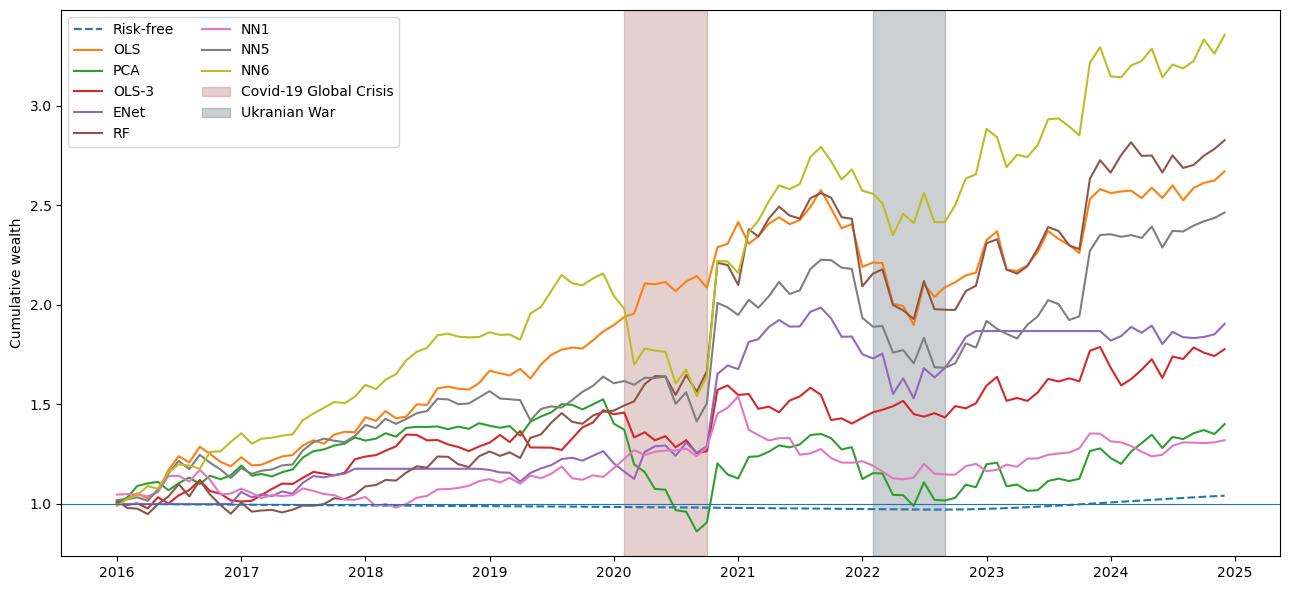

In [418]:
plt.figure(figsize=(13, 6))

plot_order = [
    "Risk-free",
    "OLS",
    "PCA",
    "OLS-3",
    "ENet",
    "RF",
    "NN1",
    "NN5",
    "NN6",
]

for name in plot_order:
    if name not in wealth:
        continue
    ls = "--" if name == "Risk-free" else "-"
    plt.plot(
        wealth[name].index,
        wealth[name].values,
        label=name,
        linestyle=ls,
    )

plt.axhline(1.0, linewidth=0.8)
plt.ylabel("Cumulative wealth")
plt.axvspan("2020-02-01", "2020-10-01", color=primaryred, alpha=0.20, label="Covid-19 Global Crisis")
plt.axvspan("2022-02-01", "2022-09-01", color=midnight, alpha=0.20, label="Ukranian War")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "cum_plot.png"),dpi=300)

plt.show()


In [422]:
sharpe_d = {}
r2_oos_d = {}


In [436]:
sharpe_d ={
    "Sharpe OLS": sharpe_ols_full,
    "Sharpe OLS_3": sharpe_ols_3,
    "Sharpe Enet": sharpe_enet,
    "Sharpe RF": sharpe_rf,
    "Sharpe NN2": 0.40,
    "Sharpe NN3": 0.61,
    "Sharpe NN4": 0.73,
    "Sharpe NN5": 0.68,
    "Sharpe NN6": 0.87,
    "Sharpe PCR": sharpe_pcr,
}

In [440]:
r2_oos_d = {
    "R_oss OLS": r2_ols,
    "R_oss OLS-3": r2_ols3,
    "R_oss Enet": r2_enet,
    "R_oss RF": r2_rf,         
    "R_oss NN1": -0.1807,
    "R_oss NN2": -0.0154,
    "R_oss NN3": 0.0063,
    "R_oss NN4": 0.0120,
    "R_oss NN5": 0.0150,
    "R_oss NN6": 0.0162,
    "R_oss PCR": r2_pcr,
}


In [442]:
print(sharpe_d)
print(r2_oos_d)

{'Sharpe OLS': 1.0329605002007047, 'Sharpe OLS_3': 0.7243268397473277, 'Sharpe Enet': 0.5884625629688307, 'Sharpe RF': 0.7357251397232917, 'Sharpe NN2': 0.4, 'Sharpe NN3': 0.61, 'Sharpe NN4': 0.73, 'Sharpe NN5': 0.68, 'Sharpe NN6': 0.87, 'Sharpe PCR': 0.30455907364766455}
{'R_oss OLS': 0.006857655810515673, 'R_oss OLS-3': 0.00934458403149474, 'R_oss Enet': 0.008059387641308313, 'R_oss RF': 0.011113594210149458, 'R_oss NN1': -0.1807, 'R_oss NN2': -0.0154, 'R_oss NN3': 0.0063, 'R_oss NN4': 0.012, 'R_oss NN5': 0.015, 'R_oss NN6': 0.0162, 'R_oss PCR': 0.008034580317453521}


In [446]:
indicators_df = (
    pd.DataFrame({
        "Sharpe": sharpe_d,
        "R_oos": r2_oos_d,
    })
    .reset_index()
    .rename(columns={"index": "Model"})
)

In [450]:
indicators_df.to_latex(
    "/Users/lucasdubois/Downloads/results_table.tex",
    index=False,
    float_format="%.3f",
    caption="Out-of-sample performance across models",
    label="tab:oos_results"
)